<a href="https://colab.research.google.com/github/jufepalacios/Deep_Learning_Model_Garbage_bags_and_Potholes_Detection/blob/main/colab/mapa_puntos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##############################################################
# Este notebook se debe correr offline
# Colab detiene la ejecución al hacer la petición al servidor
##############################################################

In [ ]:
#Código tomado de https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy
import shutil
import urllib.request as request
from contextlib import closing
import csv
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import io
import math
import random
from urllib.request import urlopen, Request
from PIL import Image

### Obtener el mapa a partir del servidor

In [ ]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [ ]:
with closing(request.urlopen('ftp://ftp.ncdc.noaa.gov/pub/data/ASOS_Station_Photos/asos-stations.txt')) as r:
    with open('asos-stations.txt', 'wb') as f:
        shutil.copyfileobj(r, f)

In [ ]:
asos_data = []
with open('asos-stations.txt','r') as dat_file:
    reader = csv.reader(dat_file)
    for row in reader:
        asos_data.append(row)

row_delin = asos_data[3][0].split(' ')[:-1]
col_sizes = [len(ii) for ii in row_delin]

col_header = []; iter_ii = 0
for ii,jj in enumerate(col_sizes):
    col_header.append(asos_data[2][0][iter_ii:iter_ii+col_sizes[ii]].replace(' ',''))
    iter_ii+=col_sizes[ii]+1
    
call,names,lats,lons,elevs = [],[],[],[],[]
for row in asos_data[4:]:
    data = []; iter_cc = 0
    for cc in range(0,len(col_header)):
        data.append(row[0][iter_cc:iter_cc+col_sizes[cc]].replace('  ',''))
        iter_cc+=col_sizes[cc]+1
    call.append(data[3])
    names.append(data[4])
    lats.append(float(data[9]))
    lons.append(float(data[10]))
    elevs.append(float(data[11]))

In [ ]:
#Generara un dataframe a partir de las ubicaciones del archivo txt
df=pd.read_csv('ubicaciones_pasto.txt',';')

In [ ]:
df.head()

,huecos,bolsas,latitud,longitud
0,1,0,1.224963,-77.285782
1,1,0,1.232590,-77.283034
2,1,0,1.232590,-77.283034
3,1,0,1.232590,-77.283034
4,1,0,1.232590,-77.283034


In [ ]:
huecos_x=[]
huecos_y=[]

bolsas_x=[]
bolsas_y=[]

for row in df.iterrows():
    actual=row[1]
    huecos=actual['huecos']
    bolsas=actual['bolsas']
    latitud=actual['latitud']
    longitud=actual['longitud']
    
    for i in range(int(huecos)):
        huecos_x.append(longitud)
        huecos_y.append(latitud)
        
    for i in range(int(bolsas)):
        bolsas_x.append(longitud)
        bolsas_y.append(latitud)
    

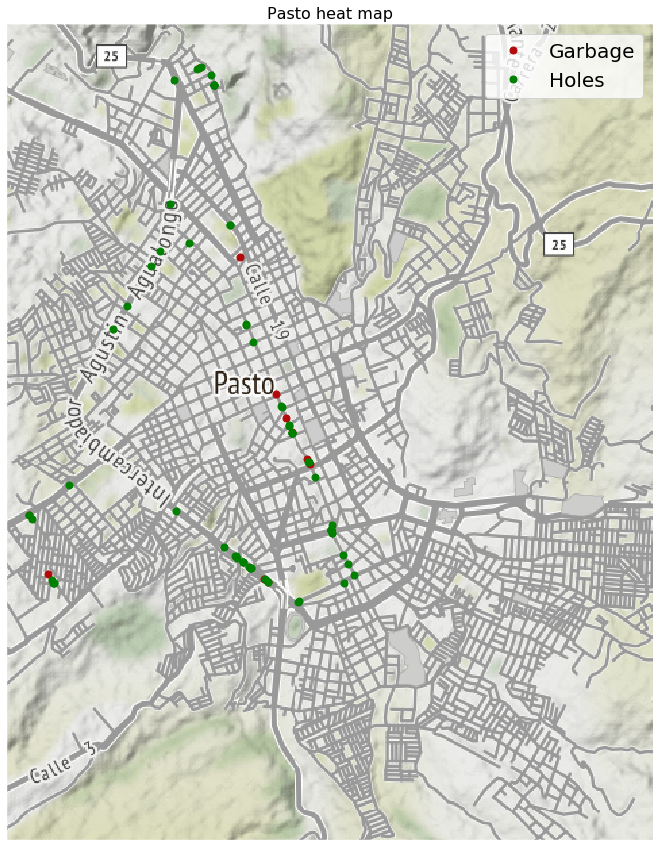

<Figure size 432x288 with 0 Axes>

In [ ]:
cimgt.Stamen.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.Stamen('terrain') # spoofed, downloaded street map

fig = plt.figure(figsize=(20,15)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
ax1.set_title('Pasto heat map',fontsize=16)

#Límites del mapa en latitud y longitud
extent = [-77.296183,-77.255034,1.18448,1.236420] # NYC bounds
ax1.set_extent(extent) # set extents
ax1.set_xticks(np.linspace(extent[0],extent[1],7),crs=ccrs.PlateCarree()) # set longitude indicators
ax1.set_yticks(np.linspace(extent[2],extent[3],7)[1:],crs=ccrs.PlateCarree()) # set latitude indicators
lon_formatter = LongitudeFormatter(number_format='0.1f',degree_symbol='',dateline_direction_label=True) # format lons
lat_formatter = LatitudeFormatter(number_format='0.1f',degree_symbol='') # format lats
ax1.xaxis.set_major_formatter(lon_formatter) # set lons
ax1.yaxis.set_major_formatter(lat_formatter) # set lats
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)



scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(14)) # add OSM with zoom specification

#######################################
# Plot the ASOS stations as points
#######################################
#
ax1.plot(bolsas_x, bolsas_y, markersize=7,marker='o',linestyle='',color='#b30909',transform=ccrs.PlateCarree(),label='Garbage')
ax1.plot(huecos_x, huecos_y, markersize=7,marker='o',linestyle='',color='green',transform=ccrs.PlateCarree(),label='Holes')
transform = ccrs.PlateCarree()._as_mpl_transform(ax1) # set transform for annotations
# text annotations
for lat_s,lon_s,name_s in zip(lats,lons,names): # loop through lats/lons/names
    if lon_s>extent[0] and lon_s<extent[1] and lat_s>extent[2] and lat_s<extent[3]:
        print(name_s)
        # annotations, with some random placement to avoid overlap
        ax1.text(lon_s, lat_s+(np.random.randn(1)*0.01),name_s, {'color': 'k', 'fontsize': 8},
                 horizontalalignment='center', verticalalignment='bottom',
                 clip_on=False,transform=transform,bbox=dict(boxstyle="round",
                   ec='#121212', fc='#fadede'))

ax1.legend(prop={'size': 20}) # add a legend
ax1.axis('off')

plt.show() # show plot


plt.savefig("map.png")
plt.show()

## Neiva

In [ ]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [ ]:
with closing(request.urlopen('ftp://ftp.ncdc.noaa.gov/pub/data/ASOS_Station_Photos/asos-stations.txt')) as r:
    with open('asos-stations.txt', 'wb') as f:
        shutil.copyfileobj(r, f)

In [ ]:
asos_data = []
with open('asos-stations.txt','r') as dat_file:
    reader = csv.reader(dat_file)
    for row in reader:
        asos_data.append(row)

row_delin = asos_data[3][0].split(' ')[:-1]
col_sizes = [len(ii) for ii in row_delin]

col_header = []; iter_ii = 0
for ii,jj in enumerate(col_sizes):
    col_header.append(asos_data[2][0][iter_ii:iter_ii+col_sizes[ii]].replace(' ',''))
    iter_ii+=col_sizes[ii]+1
    
call,names,lats,lons,elevs = [],[],[],[],[]
for row in asos_data[4:]:
    data = []; iter_cc = 0
    for cc in range(0,len(col_header)):
        data.append(row[0][iter_cc:iter_cc+col_sizes[cc]].replace('  ',''))
        iter_cc+=col_sizes[cc]+1
    call.append(data[3])
    names.append(data[4])
    lats.append(float(data[9]))
    lons.append(float(data[10]))
    elevs.append(float(data[11]))

In [ ]:
df=pd.read_csv('ubicaciones_neiva.txt',';')

In [ ]:
df.head()

,huecos,bolsas,latitud,longitud
0,0,2,2.934487,-75.244389
1,0,3,2.938852,-75.247141
2,0,3,2.938852,-75.247141
3,0,1,2.939352,-75.247279
4,0,1,2.941183,-75.247874


In [ ]:
huecos_x=[]
huecos_y=[]

bolsas_x=[]
bolsas_y=[]

for row in df.iterrows():
    actual=row[1]
    huecos=actual['huecos']
    bolsas=actual['bolsas']
    latitud=actual['latitud']
    longitud=actual['longitud']
    
    for i in range(int(huecos)):
        huecos_x.append(longitud)
        huecos_y.append(latitud)
        
    for i in range(int(bolsas)):
        bolsas_x.append(longitud)
        bolsas_y.append(latitud)
    

C:\Users\svite\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


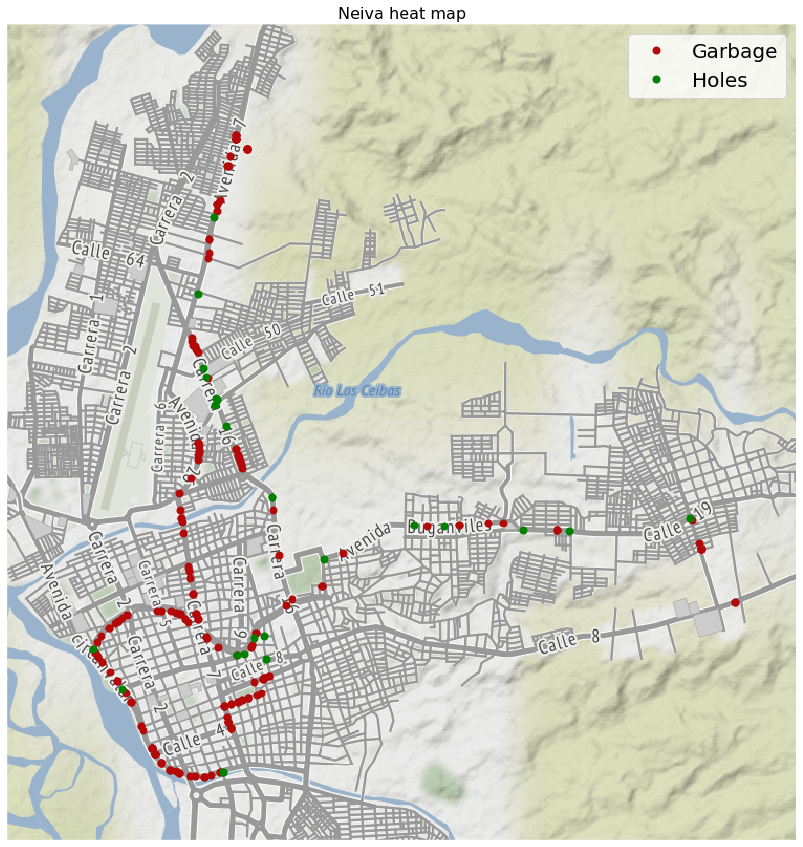

<Figure size 432x288 with 0 Axes>

In [ ]:
cimgt.Stamen.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.Stamen('terrain') # spoofed, downloaded street map

fig = plt.figure(figsize=(20,15)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
ax1.set_title('Neiva heat map',fontsize=16)
# extent = [-124.7844079,-66.9513812, 24.7433195, 49.3457868] # Contiguous US bounds
extent = [-75.239340,-75.304117 ,2.915,2.981859] # NYC bounds
ax1.set_extent(extent) # set extents
ax1.set_xticks(np.linspace(extent[0],extent[1],7),crs=ccrs.PlateCarree()) # set longitude indicators
ax1.set_yticks(np.linspace(extent[2],extent[3],7)[1:],crs=ccrs.PlateCarree()) # set latitude indicators
lon_formatter = LongitudeFormatter(number_format='0.1f',degree_symbol='',dateline_direction_label=True) # format lons
lat_formatter = LatitudeFormatter(number_format='0.1f',degree_symbol='') # format lats
ax1.xaxis.set_major_formatter(lon_formatter) # set lons
ax1.yaxis.set_major_formatter(lat_formatter) # set lats
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)



scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(14)) # add OSM with zoom specification

#######################################
# Plot the ASOS stations as points
#######################################
#
ax1.plot(bolsas_x, bolsas_y, markersize=7,marker='o',linestyle='',color='#b30909',transform=ccrs.PlateCarree(),label='Garbage')
ax1.plot(huecos_x, huecos_y, markersize=7,marker='o',linestyle='',color='green',transform=ccrs.PlateCarree(),label='Holes')
transform = ccrs.PlateCarree()._as_mpl_transform(ax1) # set transform for annotations
# text annotations
for lat_s,lon_s,name_s in zip(lats,lons,names): # loop through lats/lons/names
    if lon_s>extent[0] and lon_s<extent[1] and lat_s>extent[2] and lat_s<extent[3]:
        print(name_s)
        # annotations, with some random placement to avoid overlap
        ax1.text(lon_s, lat_s+(np.random.randn(1)*0.01),name_s, {'color': 'k', 'fontsize': 8},
                 horizontalalignment='center', verticalalignment='bottom',
                 clip_on=False,transform=transform,bbox=dict(boxstyle="round",
                   ec='#121212', fc='#fadede'))

ax1.legend(prop={'size': 20}) # add a legend
ax1.axis('off')

plt.show() # show plot


plt.savefig("map.png")
plt.show()